## Simulation of level density analysis

Simulate a spectrum (with parameters to mimic $^{154}$Sm).
1. Level spacing according to Wigner distribution.
2. Level intensity from Porter-Thomas distribution.
3. Experimental resolution of 40 keV FWHM.
4. Simulation constructed on expanded grid and then compressed into bins of 5 keV width.
5. Noise is added after the spectrum is constructed, to simulate the effect of counting statistics.
6. Only a constant spectrum.

### Results.

1. Noise correction is applied.
2. Provided $\sigma$ is kept constant, good results are obtained for both narrow smoothing and with no narrow smoothing.
3. Even with $\sigma$ a fit parameter, results are good.
4. With $\sigma$ a fit parameter and no noise correction, results are worse.

### Conclusions.

Noise corrections are important.

In [44]:
import numpy as np
import numpy.random as rnd
import spectrumtools as spt
import matplotlib.pyplot as plt
import leveldensities as ldn
import lmfit
import simlibx as sim
import spectrumtools as spt

plt.rc('font',size=16)

In [45]:
Noisy=True
#Noisy=False
# do we use narrow smoothing as well as wide?
NarrowSmooth=True
#NarrowSmooth=False

ZapCorrection=False


def simulate_spectrum(Elo,Ehi,binwidth,lineshape, sigma, factor=10.0, noisy=False):
    """
    from simlib; modified
    generate a simulted spectrum in Nspect channels
    with a mean of Npk peaks.
    Each line has a shape and width determined by linehape and sigma (in channels)
    """
    Nspect=int((Ehi-Elo)/binwidth+0.5)
    w0=binwidth/10.0
    sig=sigma/w0
    g=np.zeros(Nspect*10)
    D=0.0001054  # mean level spacing
    print('** D=',D, '    rho=',1.0/D)
    e = Elo            # peak energy
    spectrum=[]
    N=0
    while e < Ehi:
        N+=1
        x=D*sim.randomWigner()          # random level space
        y=sim.randomPT()                     # random strength
        e+=x                             # energy of level
        spectrum.append((e,y))
        ne=int((e-Elo)/w0+0.5)                    # force energy to nearest channel
        if ne<Nspect*10.0: g[ne]+=y                # into spectrum
    # convolute with line shape
    G=sim.convolute(g, lineshape, sig)#*1000.0
    #G=sim.convolute(G,lineshape,sig*0.8)
    G=G.reshape((Nspect,10))
    G=np.sum(G,axis=1)
    g=g.reshape((Nspect,10))
    g=np.sum(g,axis=1)
    #factor=10.0
    #factor=1.0
    Gshape=np.linspace(1.0,10.0,len(G))
    if noisy:
        meang=np.mean(G)
        #G=G*Gshape
        sigG=np.sqrt(meang)
        noiseG=rnd.randn(len(G))*sigG
        #print("noisy")
        #G=G+noiseG/factor
    #print(N,sig,w0,binwidth)
    return G, g, spectrum, noiseG  # improve this ?


In [46]:
# The following parameters should probably remain fixed

# lineshape for convolutions
lineshape=sim.gauss


# set smoothing parameters in channels
smoothwide=3.5 # from 3.5
smoothnarrow=0.39*2.35

alpha=2.0+0.273            # default for N=1

esig,sig=0.0,40.0 # fwhm of experimental resolution in keV  <<<<<<<<<<<<<<<<<<<<<<<<<
print("Assumed fwhm of resolution fn is %5.1f keV"%(sig))
print(":Smooth factors: wide %5.1f; narrow %5.2f"%(smoothwide,smoothnarrow))
# convert to sdev of gaussian in MeV
sig/=1000.0   # sig in MeV
sig/=2.3      # FWHM to stdev
#print("sig",sig, sig*2.3)
# calculate smoothing widths
sigsmn=smoothnarrow*sig       # < sig   . should be 0.5*FWHM ?
sigsm=smoothwide*sig       # in MeV
sigexpt=sig
sigsm0=sigsm


Assumed fwhm of resolution fn is  40.0 keV
:Smooth factors: wide   3.5; narrow  0.92


In [47]:
D=0.0001054
de=0.005
# at 5 keV / channel
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800

ROIlo=ROIlo+50
ROIhi=ROIhi+50

rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV

#rnd.seed( 75096521 )

rawG,hraw,rawspectrum,rawnoiseG=simulate_spectrum(10.0,20.0,0.005,sim.gauss,
                                         0.040/2.35,
                                         factor=10.0,noisy=Noisy)
X=np.arange(0.0,2000.0,1.0)*0.005+10.0
e=X
Nspect=len(rawG)
Nlo=ROIlo
Nhi=ROIhi
Exlo,Exhi=(e[ROIlo],e[ROIhi])
print(Exlo,Exhi)

print("ROI for analysis",Nlo, Nhi, ROIlo, ROIhi)


** D= 0.0001054     rho= 9487.666034155598
11.25 19.25
ROI for analysis 250 1850 250 1850


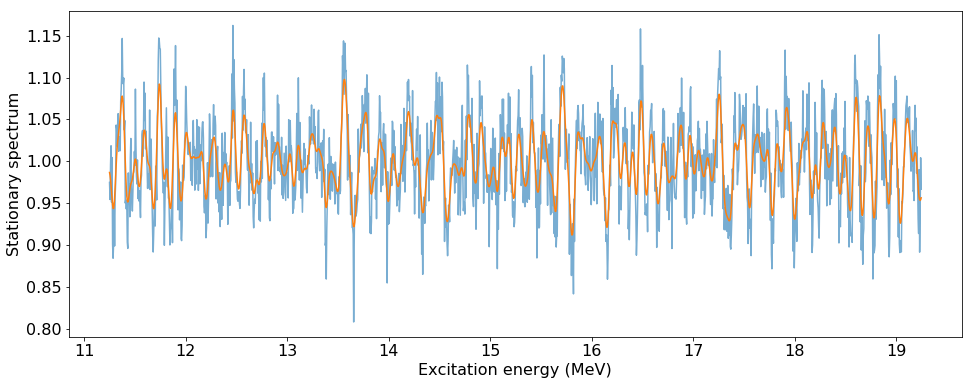

In [48]:
noisefactor=5.0
G=rawG+rawnoiseG/noisefactor
S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
globalenergy = S.energy

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

plt.figure(figsize=(16,6))
plt.plot(Eratio, ratioraw, alpha=0.6)
plt.plot(Eratio, rationar)
#plt.plot(Eratio,S.data[ROIlo:ROIhi])
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Stationary spectrum")
plt.show()

In [49]:
def PlotFullAC(nfig, Xratio,allAC,popt,alpha,sig,sigsm,initialD,A):
    plt.figure(nfig)
    #ax=plt.subplot(211)
    ax=plt.gca()
    plt.plot(Xratio[0:120]-Xratio[0], allAC[0:120]+smoothcorrection2[0:120],drawstyle='steps-mid') # was 100
    plt.plot(Xratio[0:120]-Xratio[0], allACNoNoise[0:120]-0*smoothcorrection2[0:120],'y-',drawstyle='steps-mid') # was 100
    #plt.plot(Xratio[0:120]-Xratio[0], allAC2[800:920]+0.0000,'c-',drawstyle='steps-mid') # was 100
    plt.plot(Xratio[0:120]-Xratio[0], Hansen(Xratio[0:120]-Xratio[0], popt[0],popt[1],alpha,popt[2]),'g-')
    plt.plot(Xratio[0:120]-Xratio[0], Hansen(Xratio[0:120]-Xratio[0], D,sign,alpha,sigw),'m-',alpha=0.6)
    plt.plot(Xratio[0:120]-Xratio[0], -smoothcorrection2[0:120],'c-',alpha=0.6)
    #plt.plot(Xratio[0:120]-Xratio[0], smoothcorrection2[0:120],'b-',alpha=0.6)
    ##plt.text(0.8,0.8,r"$^{%i}$Sm"%A,fontsize=16,transform=ax.transAxes)
    #plt.title(r"Autocorrelation of full region of interest")
    plt.title(r"Simulated spectrum, noise factor=%3.1f"%noisefactor)
    plt.ylabel("Autocorrelation")
    plt.xlabel("Energy offset [MeV]")
    plt.ylim(ymax=0.0022)       # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    plt.ylim(-0.002,0.0025)       # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #plt.subplot(212)
    #plt.plot(Xratio[0:750]-Xratio[0], allAC[0:750],drawstyle='steps-mid') # was 100
    #plt.plot(Xratio[0:750]-Xratio[0], Hansen(Xratio[0:750]-Xratio[0], popt[0],popt[1],alpha,sigsm))
    #plt.ylabel("Autocorrelation")
    #plt.xlabel("Energy offset [MeV]")
    return ax

# find zeros in numpy array
def findzeros(array):
    """
    very crude: only for smoothly varying stuff like autocorrelations
    """
    zerolist=[]
    for i,x in enumerate(array[1:]):  # note i=1 means index 1
        #print(i,x)
        if x*array[i]<0.0:  # (i-1)+1 !
            #print(i,x,array[i])
            zerolist.append(i+1)
    return zerolist


def fitforlm( params, e, data, unc=None ):
    """
    fit function for least sq fit using lmfit
    """
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    #sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    if unc is None:
        unc=np.ones(len(data))*p['initD']*0.2
    return (model-data)/unc

def Hansen(x, D, sig, alpha, sigw):
    """
    Plot hansen autocorrelation formula
    x: energy offset (MeV)
    D: level density
    alpha: parameter
    ys: ratio sigmasm/sigma
    11/7/2012: fix 4->2 in last term
    """

    """
    global sigsmn, sigsm0, NarrowSmooth
    if NarrowSmooth:
        if sig>sigsmn:
            sige=np.sqrt(sig**2-sigsmn**2)
        else:
            sige=sigsmn
    else:
        sige=sig
    sigw=np.sqrt(sige**2+sigsm0**2)
    #print("HHH",sig,sige,sigsmn,sigsm0,sigw)
    """
    ys=sigw/sig
    #ys=sigsm/sig
    ysp=1.+ys*ys
    #Act=np.zeros(len(x))
    #for i in range(Nac):
        #x=float(i)*de
    act=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-x*x/(4.*sig*sig))
    act+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-x*x/(4.*sig*sig*ys*ys))
    act-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D
            )*np.sqrt(8./ysp)*np.exp(-x*x/(2.*sig*sig*ysp))
        #Act[i]=act
    return act

def Fitf3(x,v0,sig,sigw):
    global alpha
    ys=sigw/sig
    ysp=1.+ys*ys
    act=v0*np.exp(-x*x/(4.*sig*sig))
    act+=(v0/ys)*np.exp(-x*x/(4.*sig*sig*ys*ys))
    act-=v0*np.sqrt(8./ysp)*np.exp(-x*x/(2.*sig*sig*ysp))
    return act


NarrowSmooth  True
ZapCorrection False
Varysign      False

New point, noisefactor= 10.0
fluctuation parameters sigsm: 0.061, sig: 0.017, sigsmn: 0.016, ys:  2.68
fluctuation parameters fwhm. sigsm:  0.140, sig:  0.040, sigsmn:  0.037
Raw mean 47.22, smooth mean 47.23
rawAC0 is 0.0020464
Varnoise: 0.000286 from Ac[0],AC[1]=0.002240,0.001954
Varnoise: 0.000209 from raw noise
smoothcorrr 1.2100228377544814e-05 -1.3782980048403903e-05
raw AC at 0: 0.001071
mean AC at 0.3-> : 0.999636
allAC fit2 input (sign,sigw,alpha,ys,widthROId2) 0.0236 0.0633  2.273  2.684 800
initialD 0.000102 estimated from AC 0.001071
Narrow smooth applied to spectrum
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 30
    # variables        = 1
    chi-square         = 22.636
    reduced chi-square = 0.781
    Akaike info crit   = -6.450
    Bayesian info crit = -5.049
[[Variables]]
    D:       9.8815e-05 +/- 6.84e-07 (0.69%) (init= 0.0001023063)
    sign:    0.02359054 (fixed)
    sigw:    0

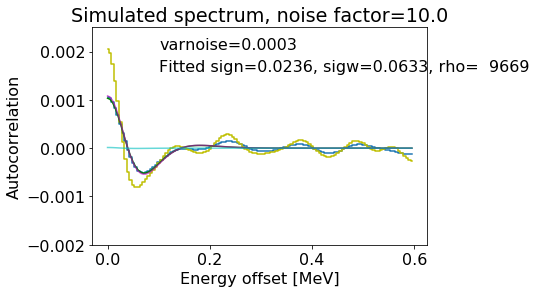

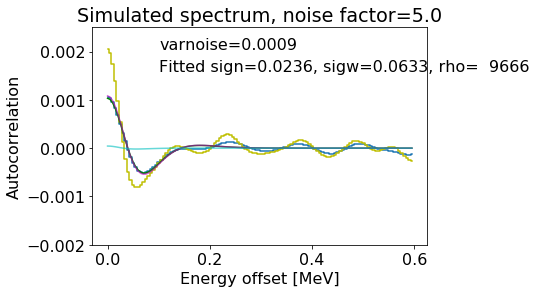

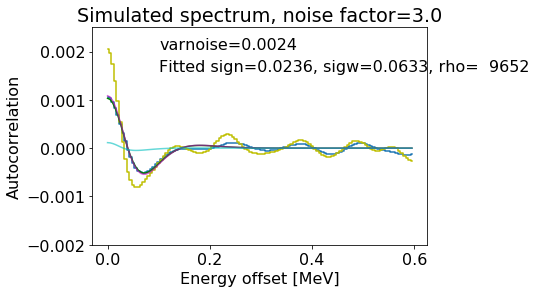

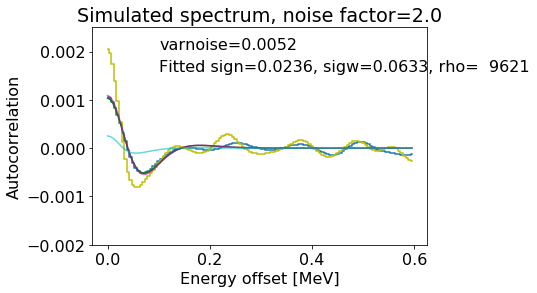

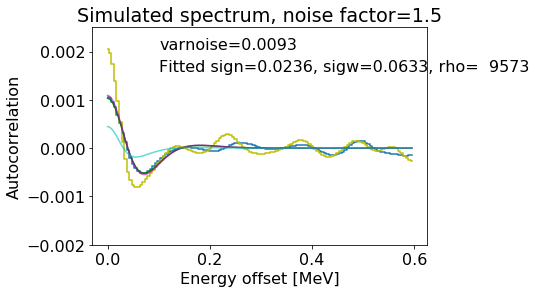

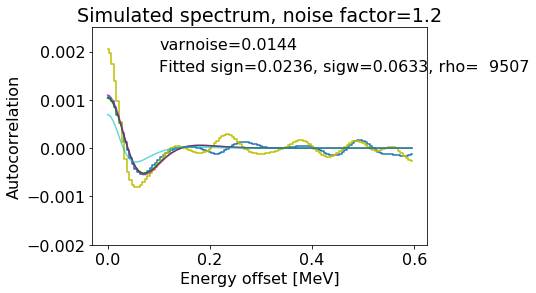

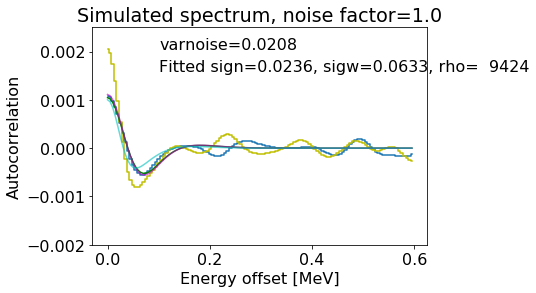

In [52]:
ifig=1
Varysign=False
print("NarrowSmooth ",NarrowSmooth)
print("ZapCorrection", ZapCorrection)
print("Varysign     ", Varysign)
for noisefactor in [10.0,5.0,3.0,2.0,1.5,1.2,1.0]:
#for noisefactor in [1.0]:


    # Basic spectrum -----------

    G=rawG+rawnoiseG/noisefactor

    #---------------------------

    if NarrowSmooth:
        Gn=sim.convolute(G, lineshape, sigsmn/de)
        iAC=0             # first point in autocorrelation fit
        firstoffset=0.0       # energy offset of first point
    else:                 # if no narrow smooth, ignore noise in first channel
        Gn=G
        iAC=1
        firstoffset=de


    # smooth spectrum by convoluting with gaussian of width sigsm channels: g_>
    Gs=sim.convolute(G, lineshape, sigsm/de)
    Gs[Gs<0.2]=0.2  #  lower limit (prevents div by zeros) needs more thought ...
    rawGs=sim.convolute(rawG, lineshape, sigsm/de)
    rawGs[rawGs<0.2]=0.2  #  lower limit (prevents div by zeros) needs more thought ...

    # increase sig to account for convolution of g
    sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
    sign=sig
    if NarrowSmooth:
        sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
        sigaim=sig
    ys=sigw/sign

    print()
    print("New point, noisefactor=%5.1f"%(noisefactor))
    print("fluctuation parameters sigsm:%6.3f, sig:%6.3f, sigsmn:%6.3f, ys:%6.2f"%(sigsm,sig,sigsmn,ys))
    print("fluctuation parameters fwhm. sigsm: %6.3f, sig: %6.3f, sigsmn: %6.3f"%(sigsm*2.3,sig*2.3, sigsmn*2.3))

    # make ratio spectrum in full ROI
    #ROIlo=800
    #ROIhi=1200
    widthROI=ROIhi-ROIlo
    TG=G[ROIlo:ROIhi]
    TGn=Gn[ROIlo:ROIhi]
    TS=Gs[ROIlo:ROIhi]
    rawTS=rawGs[ROIlo:ROIhi]
    Gratio0=G[ROIlo:ROIhi]/Gs[ROIlo:ROIhi]
    Gratio=Gn[ROIlo:ROIhi]/Gs[ROIlo:ROIhi]
    Xratio=X[ROIlo:ROIhi]
    meanTS=np.mean(TS)
    meanrawTS=np.mean(rawTS)
    rawfact=meanrawTS/meanTS

    TN=rawnoiseG[ROIlo:ROIhi]
    GratioNonoise=(rawG[ROIlo:ROIhi])/rawTS
    allACNoNoise,pspc=sim.autocorrelation(GratioNonoise)

    print("Raw mean %5.2f, smooth mean %5.2f"%(np.mean(rawG[ROIlo:ROIhi]),np.mean(TS)))
    print("rawAC0 is %9.7f"%allACNoNoise[0])
    # find effect of noise
    allACnn,pspc=sim.autocorrelation(Gratio0)
    #print()
    if allACnn[1]>0.0:
        varnoise=allACnn[0]-allACnn[1]
        print("Varnoise: %8.6f from Ac[0],AC[1]=%8.6f,%8.6f"%(varnoise,allACnn[0],allACnn[1]))
    else:
        varnoise=allACnn[0]
    rawvarnoise=np.var(TN/noisefactor)/meanTS**2
    print("Varnoise: %8.6f from raw noise"%(rawvarnoise))
    #print("mean TS",meanTS,np.mean(rawTS))
    # correction includes two terms. should be recalculated for noise delta.
    yn=sigsm/de
    rawvarnoise=varnoise # in princ. we have to get this from expt.
    # as per Hansen
    smoothcorrection=-rawvarnoise*(de/(2.0*np.sqrt(np.pi)*de))*(
        (1/yn)*np.exp(-(Xratio-Xratio[0])**2/(4.0*de**2*yn**2))-
        np.sqrt(8/(1+yn**2))*np.exp(-(Xratio-Xratio[0])**2/(2.0*de**2*(1+yn**2))))
    # modified as per notes of 25/4/2018
    smoothcorrection=-rawvarnoise*(de/(2.0*np.sqrt(np.pi)*de))*(
        (1/yn)*np.exp(-(Xratio-Xratio[0])**2/(4.0*de**2*yn**2))-
        np.sqrt(8/yn**2)*np.exp(-(Xratio-Xratio[0])**2/(2.0*de**2*yn**2)))
    if NarrowSmooth:
        smoothcorrection2=-sim.ACnoise((Xratio-Xratio[0]),sigsmn,sigsm,de,rawvarnoise)
    else:
        smoothcorrection2=-sim.ACnoise_nonsm((Xratio-Xratio[0]),de,sigsm,de,rawvarnoise)
        
    if ZapCorrection:
        smoothcorrection2=np.zeros(len(Xratio))


    print("smoothcorrr",smoothcorrection[0],smoothcorrection2[0])
    # find basic details from full autocorrelation
    allAC,pspc=sim.autocorrelation(Gratio)
    print("raw AC at 0: %8.6f"%allAC[0])
    meanAC=np.mean(Gratio[int(0.3/de):(ROIhi-ROIlo)//2])
    print("mean AC at 0.3-> : %8.6f"%meanAC)
    widthROId2=widthROI//2
    zerolist=findzeros(allAC)
    #widthROId2=zerolist[1]+1
    print("allAC fit2 input (sign,sigw,alpha,ys,widthROId2) %6.4f %6.4f %6.3f %6.3f %d"%(sign,sigw,alpha,ys,widthROId2))
    ###ys=3.9716 ####
    initialD=allAC[iAC]/Hansen(firstoffset,1.0,sign,alpha,sigw)
    print("initialD %8.6f estimated from AC %8.6f"%(initialD,allAC[iAC]))
    widthROId2=30
    fitX=Xratio[iAC:widthROId2]-Xratio[0]
    if NarrowSmooth:
        print("Narrow smooth applied to spectrum")
    else:
        print("NO narrow smooth applied to spectrum")         
        print("Spectrum in fit corrected for noise in wide smooth")
    fitallAC=allAC[iAC:widthROId2]+smoothcorrection2[iAC:widthROId2]
    dAC=widthROId2
    varAc0=(allAC[iAC]**2/dAC)*(12-1+2/(dAC+1))
    Mfit=fitallAC.size
    fitsigma=np.ones(Mfit)*np.sqrt(varAc0)
    sigx=sigsm*2

    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    #params.add('sign',value=sig,min=0.0,vary=True)
    #params.add('sigw',value=sigsm,min=0.0,vary=False)
    params.add('sign',value=sign,min=0.0,vary=Varysign)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    params.add('initD',value=initialD,vary=False)
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(fitX,fitallAC),
                           fcn_kws={'unc':None})
    result=minner.minimize()
    #lmfit.printfuncs.report_fit(result.params)
    #print(result.redchi)
    lmfit.printfuncs.report_fit(result)
    #print(lmfit.fit_report(result))
    p=result.params.valuesdict()
    rho=1.0/p['D']
    D=fitallAC[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)
    rho=1/D

    popt=[p['D'],p['sign'],p['sigw']]
    print("allAC fit: p[0],p[1] p[2] varAc0 %6.4f %6.4f %6.4f %6.4f"%(popt[0],popt[1],popt[2],np.sqrt(varAc0)))

    # rearrange for lmfit ...
    calcD=popt[0] #*2.0*np.sqrt(np.pi)*popt[1]/alpha
    popt[0]=popt[0]/2.0*np.sqrt(np.pi)*popt[1]/alpha

    ac0=Hansen(0.0, calcD, popt[1], alpha, popt[2])
    print("Calculted AC0 %8.6f"%ac0)
    print("allAC fit D=%9.7f, init D=%9.7f, rho=%6.0f"%(calcD, initialD, 1.0/calcD))
    # get hansen factor at 0
    hansenf0=Fitf3(0.0,1.0,popt[1],popt[2])
    # correct for noise
    if NarrowSmooth:
        f1=2.0*np.sqrt(np.pi)*(sigsmn/de)
        varnoise=varnoise/f1
        correctedD=(popt[0]-varnoise)*2.0*np.sqrt(np.pi)*popt[1]/alpha
        print("correctedD=%9.7f, rho=%6.0f, varnoise=%9.7f, var=%8.6f, hansenf0=%6.3f "%(correctedD, 1.0/correctedD, varnoise, popt[0]-varnoise, hansenf0))
    #sig=popt[1]
    """
    if NarrowSmooth:
        sige=np.sqrt(sig**2-sigsmn**2)
    else:
        sige=sig
        sigw=np.sqrt(sige**2+sigsm0**2)
    """
    sige=sig
    ys=sigw/sig
    print("Fitted sign=%6.4f, sigw=%6.4f, sige=%6.4f, ys=%6.3f"%(popt[1], popt[2], sige,ys))
    # plot AC of full ROI
    popt[0]=calcD
    ax=PlotFullAC(ifig, Xratio,allAC,popt,alpha,sign,popt[2],initialD,1)
    ifig+=1
    ##plt.text(0.8,0.8,r"$^{%i}$Sm"%A,fontsize=16,transform=ax.transAxes)
    ax.text(0.2,0.9,
            "varnoise=%6.4f"%(rawvarnoise),
            transform=ax.transAxes)
    ax.text(0.2,0.8,
            "Fitted sign=%6.4f, sigw=%6.4f, rho=%6.0f"%(popt[1], popt[2],
                                                        1.0/calcD),
            transform=ax.transAxes)
    #plt.show()
    # **************************
    #sys.exit(3)
    # **************************
